In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [2]:
# Load the data
df = pd.read_csv('data_traveloka.csv')

# Data preprocessing
def preprocess_price(price_str):
    """Convert price string to numeric value"""
    if isinstance(price_str, str):
        # Remove 'Rp', dots, and convert to float
        price_str = price_str.replace('Rp', '').replace('.', '').strip()
        try:
            return float(price_str)
        except:
            return np.nan
    return price_str

# Apply preprocessing to price columns
df['Original price'] = df['Original price'].apply(preprocess_price)
df['Price after discount'] = df['Price after discount'].apply(preprocess_price)

# Handle missing values
df = df.dropna(subset=['Original price', 'Price after discount'])

# Extract location information (simplify to main area)
def extract_main_location(location):
    if isinstance(location, str):
        # Take the first part before comma
        return location.split(',')[0].strip()
    return location

df['main_location'] = df['location'].apply(extract_main_location)

# Handle rating - convert to numeric, handle 'n/a'
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Rating'] = df['Rating'].fillna(df['Rating'].median())

# Feature engineering
# Create features that might be useful for prediction
df['discount_percentage'] = ((df['Original price'] - df['Price after discount']) / df['Original price']) * 100

# Encode categorical variables
le_location = LabelEncoder()
df['location_encoded'] = le_location.fit_transform(df['main_location'])

In [3]:
# Prepare features and target
features = ['Rating', 'location_encoded', 'discount_percentage']
target = 'Price after discount'

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")


Model Performance:
MAE: 996,943.24
RMSE: 2,411,654.49
R² Score: 0.0970


In [4]:
# Function to predict price for new data
def predict_accommodation_price(rating, location, discount_percentage=0):
    """
    Predict accommodation price based on features

    Parameters:
    rating: float (1-10)
    location: str (one of the locations in the dataset)
    discount_percentage: float (0-100)
    """
    try:
        # Encode location
        location_encoded = le_location.transform([location])[0]
    except:
        print(f"Location '{location}' not found in training data. Using average location encoding.")
        location_encoded = le_location.transform(['Kuta'])[0]  # Default to Kuta

    # Prepare features
    features = np.array([[rating, location_encoded, discount_percentage]])
    features_scaled = scaler.transform(features)

    # Predict
    predicted_price = model.predict(features_scaled)[0]

    return predicted_price

# Example predictions
print("\nExample Predictions:")
locations_to_test = ['Kuta', 'Seminyak', 'Ubud', 'Nusa Dua']
for location in locations_to_test:
    predicted = predict_accommodation_price(8.5, location, 20)
    print(f"Predicted price for {location} (rating 8.5, 20% discount): Rp {predicted:,.0f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)



Example Predictions:
Predicted price for Kuta (rating 8.5, 20% discount): Rp 900,271
Predicted price for Seminyak (rating 8.5, 20% discount): Rp 1,194,862
Predicted price for Ubud (rating 8.5, 20% discount): Rp 1,889,313
Predicted price for Nusa Dua (rating 8.5, 20% discount): Rp 736,795

Feature Importance:
               feature  importance
1     location_encoded    0.461254
2  discount_percentage    0.333141
0               Rating    0.205606


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


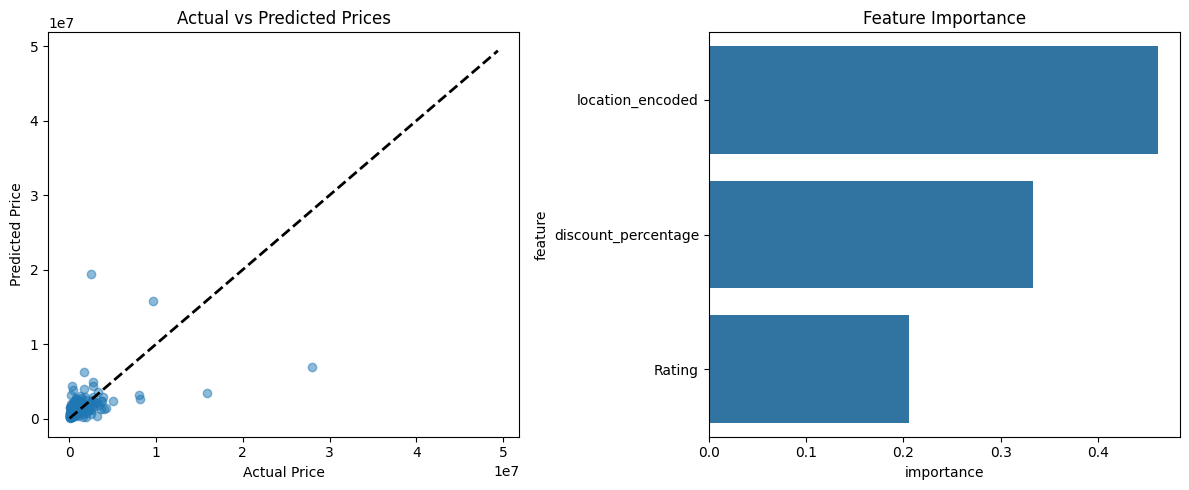


Model saved as 'accommodation_price_predictor.pkl'


In [5]:
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')

plt.subplot(1, 2, 2)
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# Save the model for future use
import joblib
joblib.dump(model, 'accommodation_price_predictor.pkl')
joblib.dump(scaler, 'price_scaler.pkl')
joblib.dump(le_location, 'location_encoder.pkl')

print("\nModel saved as 'accommodation_price_predictor.pkl'")

In [6]:
# Load the saved model
model = joblib.load('accommodation_price_predictor.pkl')
scaler = joblib.load('price_scaler.pkl')
le_location = joblib.load('location_encoder.pkl')

# Predict price for a new accommodation
predicted_price = predict_accommodation_price(9.0, 'Seminyak', 15)
print(f"Predicted price: Rp {predicted_price:,.0f}")

Predicted price: Rp 2,223,214


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
